In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
# =============
# -user config-
# =============
scanStep=1
height=12
detectLen=49.4
pointCnt=471
angleStart=35
angleStep=1
gridn=100

In [4]:
data = pd.read_csv("../data/dataExported.csv")
print(data)

         Frame  Beam  Point  Value
0            0     0      0    486
1            0     0      1    610
2            0     0      2    469
3            0     0      3    450
4            0     0      4    192
...        ...   ...    ...    ...
4723771    277    35    467    275
4723772    277    35    468    244
4723773    277    35    469    177
4723774    277    35    470    179
4723775    277    35    471    298

[4723776 rows x 4 columns]


低通滤除幅值较低的点

Flitered points count: 2565331


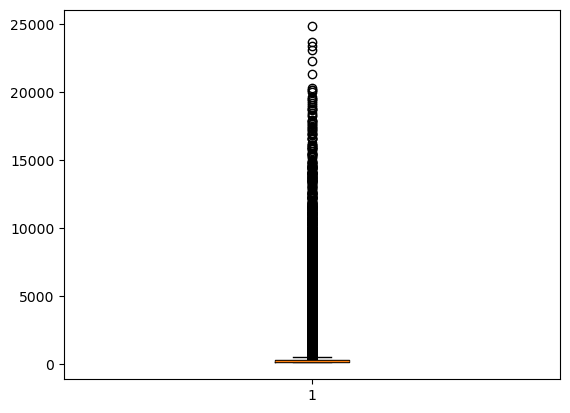

In [5]:
%matplotlib inline
data_high = data.loc[data['Value'] > 100]
print("Flitered points count: " + str(len(data_high)))
plt.boxplot(data_high['Value'])
plt.show()

原射线坐标系原生转换三维坐标系

In [6]:
def to3dAxes(frame, beam, point, reflection = True):
    x = frame * scanStep
    angleBeam = (angleStart + angleStep * beam) * math.pi / 180
    pointLen = detectLen * (point + 1) / pointCnt
    z = pointLen * np.sin(angleBeam)
    yFull = pointLen * np.cos(angleBeam)
    y = yFull
    if reflection == True:
        y = y % (2 * height)
        y[y > height] = 2 * height - y[y > height]
    return x, y, z



x, y, z = to3dAxes(data['Frame'].values, data['Beam'].values, data['Point'].values, reflection=False)
v = data['Value'].values
data_3d = pd.DataFrame({'x': x, 'y': y, 'z': z, 'value': v})
print(data_3d)

           x          y          z  value
0          0   0.085915   0.060159    486
1          0   0.171831   0.120317    610
2          0   0.257746   0.180476    469
3          0   0.343661   0.240634    450
4          0   0.429577   0.300793    192
...      ...        ...        ...    ...
4723771  277  16.788179  46.125141    275
4723772  277  16.824051  46.223699    244
4723773  277  16.859923  46.322257    177
4723774  277  16.895795  46.420815    179
4723775  277  16.931667  46.519373    298

[4723776 rows x 4 columns]


插值到点阵结构

In [7]:
%matplotlib
from scipy.interpolate import LinearNDInterpolator
from matplotlib.colors import LinearSegmentedColormap

def getGrid2D():
    axis = np.linspace(0, detectLen, num=gridn)
    return np.meshgrid(axis, axis)

def toGridData2D(y, z, value):
    # 生成对应grid数据
    yi = np.linspace(0, detectLen, num=gridn)
    zi = np.linspace(0, detectLen, num=gridn)
    yi, zi = np.meshgrid(yi, zi)
    interp = LinearNDInterpolator(list(zip(y, z)), value, fill_value=0)
    valuei = interp(yi, zi)
    return yi, zi, valuei

def drawAScan(x2d, y2d, value2d):
    my_color = [(0,'#FFFFFF'),(0.33,'#0000FF'),(0.66,'#00FF00'),(1,'#FF0000')]
    my_cmap = LinearSegmentedColormap.from_list('my_cmap', my_color)
    fig, ax = plt.figure(), plt.axes()
    im = ax.pcolormesh(x2d, y2d, value2d, shading='auto', cmap=my_cmap)
    ax.set(xlim=(0, detectLen), ylim=(0, detectLen))
    ax.invert_yaxis()
    fig.colorbar(im)
    plt.show(block=True)



# numpy 按frame存储的矩阵数组
data_clips = []

for frame in range(max(data_3d['x'].values) + 1):
    data_3df = data_3d.loc[data_3d['x']==frame, ['y', 'z', 'value']]
    yf, zf, vf = data_3df['y'].values, data_3df['z'].values, data_3df['value'].values
    yf_g, zf_g, vf_g = toGridData2D(yf, zf, vf)
    #drawAScan(zf_g, yf_g, vf_g)
    data_clips.append(np.array(vf_g))
    print("\rcurrent frame: {}".format(frame), end="")

print(len(data_clips))

Using matplotlib backend: <object object at 0x000002516FB29620>
current frame: 277278


均值衰减过滤结构噪声

In [8]:
def reductMean(matrixArr, a=0.9):
    if len(matrixArr) == 0:
        return None
    mean = np.zeros_like(matrixArr[0])
    reduc = np.zeros_like(matrixArr[0])
    for matrix in matrixArr:
        reduc = reduc * a + matrix
        mean = mean + reduc
    mean = mean / len(matrixArr)
    return mean



meanFrame = reductMean(data_clips)
print(meanFrame)
gridY, gridZ = getGrid2D()
drawAScan(gridZ, gridY, meanFrame)

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.         3367.45682177    0.         ...    0.
     0.            0.        ]
 [   0.         3340.80078376 3062.74074897 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


可视化三维散点图像

In [9]:
# TODO